# Final Project

**Aakash Agrawal** <br/>
**A69034394** <br/>
aaa015@ucsd.edu

Since I talked about **Concept Bottleneck Models (CBMs)** in my presentation as well as the critical review; as a part of my final project, I plan to try out the SOTA **Label Free CBM** and explore their benefits over traditional CBM. Specifically, I chose this project idea to gain hands-on experience working with Concept Bottleneck Models (CBMs).

In this notebook, I aim to reproduce the claims made by the authors of the paper: https://arxiv.org/abs/2304.06129. I check the validity of the concepts learned, the results claimed, and see if interventions work.  

The authors have provided the link to their model and datasets: https://github.com/Trustworthy-ML-Lab/Label-free-CBM. The below work is built on top of their codebase and is reproducible. 

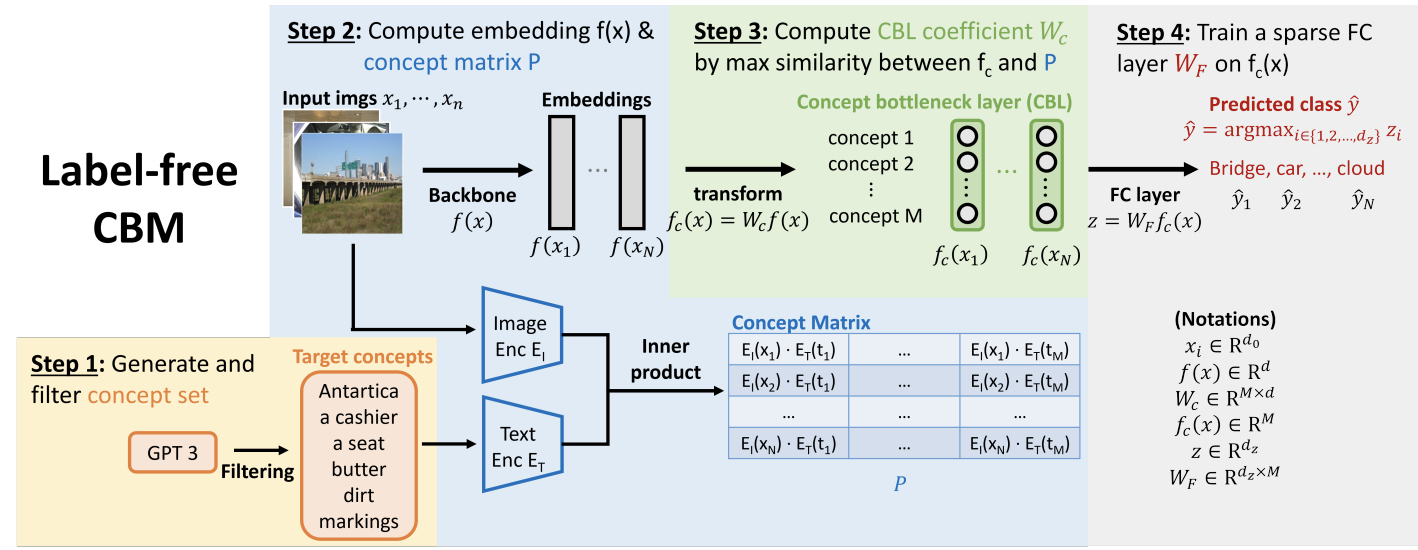

In [1]:
from IPython.display import Image
Image(filename='../data/architecture.png', width=800)

## Label Free CBM

In [2]:
# import desired libraries
import os
os.chdir("..")

import json
import torch
import data_utils

import cbm
import plots

import warnings 
warnings.simplefilter("ignore")

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
# specify the directory where the model is saved
load_dir = "saved_models/places365_lf_cbm/"

# specify the device to run the code on (e.g., "cpu" or "cuda" for GPU)
device = "cpu"

# this file typically contains model parameters and other settings
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)

dataset = args["dataset"]

# prepare the target preprocessing function based on the specified backbone model
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)

# load the Concept-Based Model (CBM) from the specified directory
model = cbm.load_cbm(load_dir, device)

In [4]:
# construct the validation dataset name
val_d_probe = dataset + "_val"  

# retrieve the corresponding class label file for the dataset from the predefined mapping
cls_file = data_utils.LABEL_FILES[dataset]

# load the validation dataset with the specified preprocessing function applied to the targets
# this ensures the targets are in the correct format for the model
val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)  

# load the validation dataset as PIL images (without any preprocessing applied to the targets)
# useful for operations requiring raw image data
val_pil_data = data_utils.get_data(val_d_probe)

In [5]:
# open the class file and concepts file
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

### Visualising Concept Set
365 Places Dataset

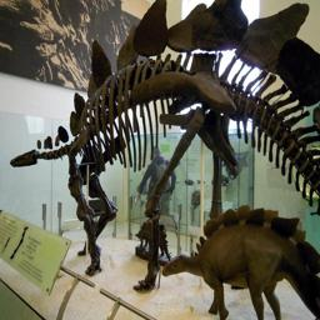

Image:10036 
Gt:natural history museum, 
1st Pred:natural history museum, 12.945, 
2nd Pred:science museum, 9.990




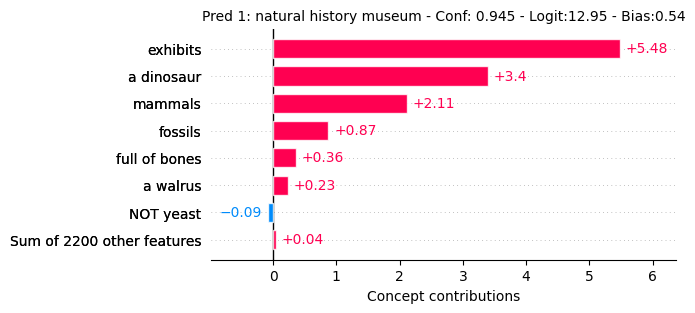

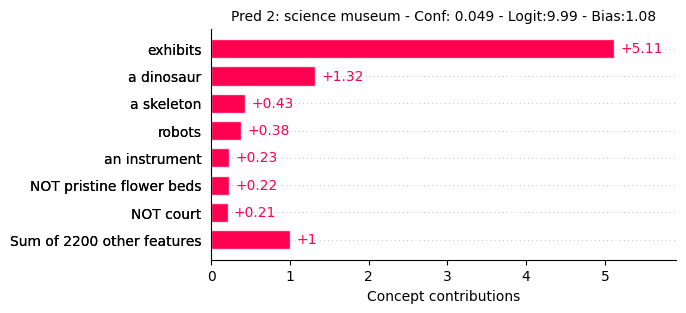

In [8]:
# select a random datapoint for visualisation
import random
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(2, 6))

to_display = [random.randint(0, len(val_pil_data))]

# disable gradient calculations to improve performance and reduce memory usage during inference
with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i] # x is (3, 224, 224)

        # add a batch dimension to the input tensor
        x = x.unsqueeze(0).to(device) # x is (1, 3, 224, 224)
        display(image.resize([320, 320]))

        # perform a forward pass to get the model's outputs and the activation of concepts
        outputs, concept_act = model(x)

        # get the top 2 predicted class labels and their corresponding logit values
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)

        # convert logits to probabilities (confidence scores)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} \nGt:{}, \n1st Pred:{}, {:.3f}, \n2nd Pred:{}, {:.3f}".format(
            i, 
            classes[int(label)], 
            classes[top_classes[0]], top_logit_vals[0],
            classes[top_classes[1]], top_logit_vals[1]
        ))

        # loop over the top 2 predictions
        for k in range(2):
            print("\n")
            # calculate the contributions of the concepts to the logit for each predicted class
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]

            # create a list of feature names, where concepts with negative activations are prefixed with "NOT"
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()

            # only display significant ones features
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(
                k+1, 
                classes[top_classes[k]],
                conf[top_classes[k]], 
                top_logit_vals[k], 
                model.final.bias[top_classes[k]]
            )
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=10)

As we can see that in addition to accurate predictions, CBMs also help interpret the models output using concepts. However, these concepts dont require any expert annotations.

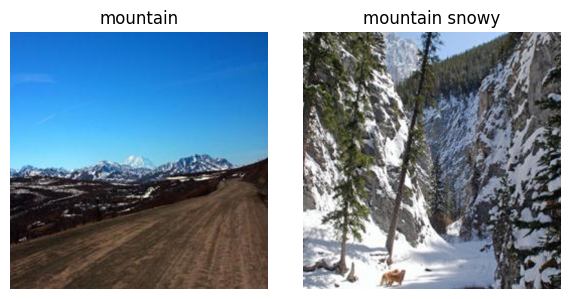

In [9]:
# visualising the final layer weights for different classes
import numpy as np

idx_1 = classes.index('mountain')
idx_2 = classes.index('mountain snowy')

weights_class_1 = model.final.weight[idx_1, :]
weights_class_1 = weights_class_1.detach().numpy()

weights_class_2 = model.final.weight[idx_2, :]
weights_class_2 = weights_class_2.detach().numpy()

# show images
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(val_pil_data[40][0].resize((400, 400)))
axes[0].set_title("mountain")
axes[0].axis("off")  # Turn off axis

axes[1].imshow(val_pil_data[204][0].resize((400, 400)))
axes[1].set_title("mountain snowy")
axes[1].axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

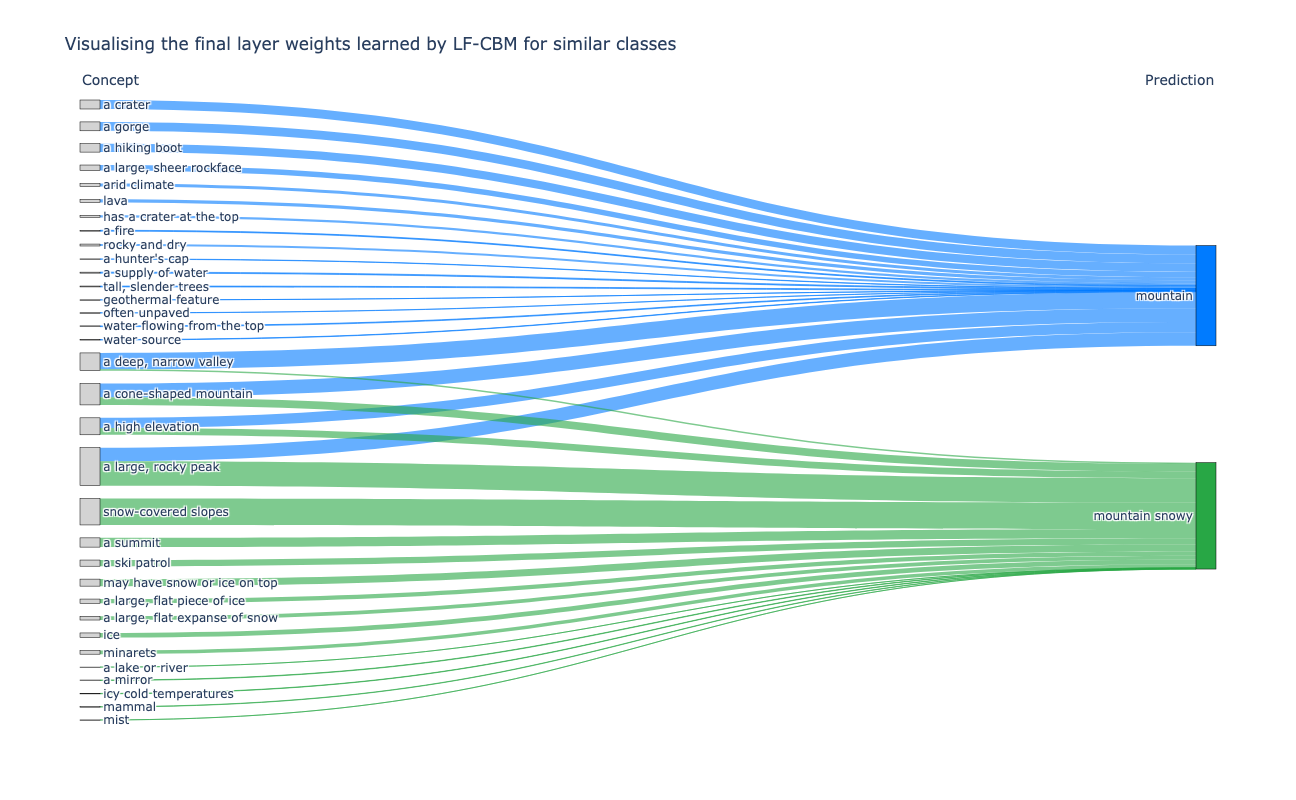

In [10]:
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

# Create source-target pairs and values based on the weights
sources = []
targets = []
values = []
colors = []

# Mapping concept nodes to class nodes
for i, weight in enumerate(weights_class_1):
    if weight != 0:
        sources.append(i)
        targets.append(len(concepts))
        values.append(weight)
        colors.append('rgba(0, 123, 255, 0.6)')

# Class 2 will be linked to the concept nodes on the left
for i, weight in enumerate(weights_class_2):
    if weight != 0:
        sources.append(i)
        targets.append(len(concepts) + 1)
        values.append(weight)
        colors.append('rgba(40, 167, 69, 0.6)')

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=concepts + list(np.array(classes)[[idx_1, idx_2]]),
        color=['#D3D3D3']*len(concepts) + ['#007BFF', '#28A745']
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors
    )
))

# Add titles for the left and right columns (Concept and Prediction)
fig.update_layout(
    title_text="Visualising the final layer weights learned by LF-CBM for similar classes",
    font_size=12,
    height=800,
    width=1000,
    annotations=[
        dict(
            x=0, y=1.05,
            xref="paper", yref="paper",
            text="Concept",
            showarrow=False,
            font=dict(size=14),
            align="center"
        ),
        dict(
            x=1, y=1.05,
            xref="paper", yref="paper",
            text="Prediction",
            showarrow=False,
            font=dict(size=14),
            align="center"
        )
    ]
)

fig.show()

### Interventions 
We intervene on "hangers" concept to correct prediction

In [11]:
# select a random datapoint for visualisation
def inference(datapoint_idx, intervention=False):
    # disable gradient calculations to improve performance and reduce memory usage during inference
    with torch.no_grad():
        for i in datapoint_idx:
            image, label = val_pil_data[i]
            x, _ = val_data_t[i] # x is (3, 224, 224)
    
            # add a batch dimension to the input tensor
            x = x.unsqueeze(0).to(device) # x is (1, 3, 224, 224)
            display(image.resize([320, 320]))
    
            # perform a forward pass to get the model's outputs and the activation of concepts
            _, concept_act = model(x)
    
            # intervene to change hat activation to 0
            if intervention:
                concept_act[0, concepts.index("hangers")] = 0
            outputs = model.final(concept_act)
    
            # get the top 2 predicted class labels and their corresponding logit values
            top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=1)
    
            # convert logits to probabilities (confidence scores)
            conf = torch.nn.functional.softmax(outputs[0], dim=0)
            print("Image:{} \nGt:{}, \n1st Pred:{}, {:.3f}".format(
                i, 
                classes[int(label)], 
                classes[top_classes[0]], top_logit_vals[0]
            ))
    
            print("\n")
            # calculate the contributions of the concepts to the logit for each predicted class
            contributions = concept_act[0]*model.final.weight[top_classes[0], :]

            # create a list of feature names, where concepts with negative activations are prefixed with "NOT"
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()

            # only display significant ones features
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(
                1, 
                classes[top_classes[0]],
                conf[top_classes[0]], 
                top_logit_vals[0], 
                model.final.bias[top_classes[0]]
            )
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=10)

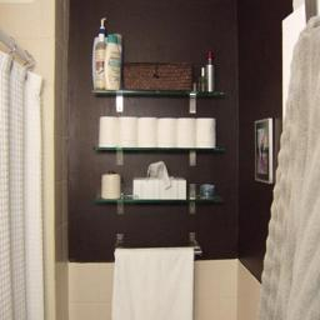

Image:11577 
Gt:bathroom, 
1st Pred:closet, 8.098




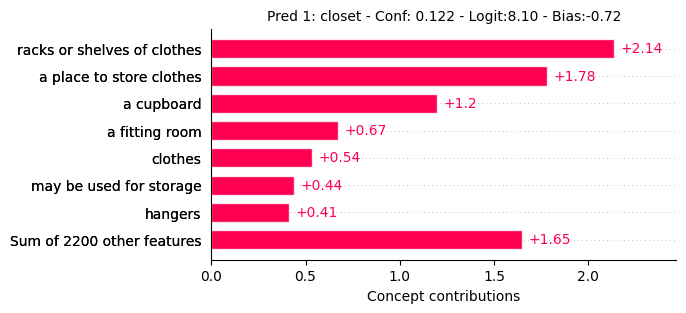

In [12]:
# inference, no intervention
inference([11577], intervention=False)

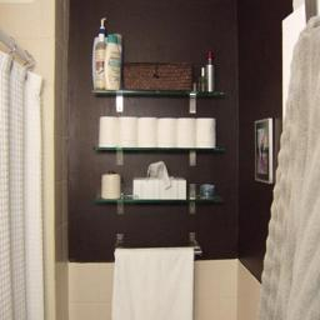

Image:11577 
Gt:bathroom, 
1st Pred:bathroom, 7.710




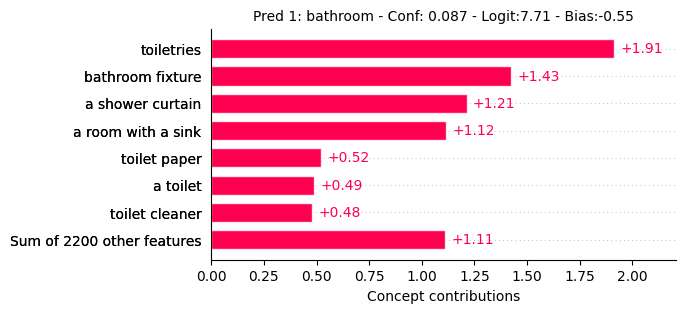

In [13]:
# with intervention on hangers concept
inference([11577], intervention=True)



<div style="text-align: justify">
As we saw, intervening on the concept hanger (making the concept zero zero), makes the final predictions correct. Overall, I feel that the concept set generated using LF-CBM is comprehensive and intuitive. We clearly saw that the LF-CBM model was able to distinguish between similar classes, thereby also preserving the <font style="color:green"> performance</font>. Further, I think that this work makes CBMs more accessible and removes the major overhead of expensive concept annotations. I played around with different datasets and got a good hands-on on the benefits of CBM.
<font style="color:red">However, the authors use OpenAI APIs for generating concept sets and I feel that is also a costly proespect. Hence, I think the claim of annontating the concepts free of cost is slightly far fetched.
</div><br>
